<img src="https://raw.githubusercontent.com/eilyich/Kinotochka_model_dev/master/model/media/logo.jpg" width="784">


# Рекомендательная система для Kinotochka

Цель проекта заключается в создании рекомендательной системы, предлагающей пользователям фильмы, исходя из их предпочтений, но при этом учитывающей только те ленты, которые пользователь ещё не смотрел (не оценил на сервисе). Такой подход гарантирует, что каждый пользователь получит новые и интересные предложения, что делает сервис более привлекательным. Персональные рекомендации будут показываться в разделе "специально для вас".

#### Потенциальные преимущества для бизнеса:   
- **Персонализация**: Система обеспечит пользователей рекомендациями, наиболее соответствующими их вкусам и интересам.
- **Увеличение удержания**: Пользователи будут чаще возвращаться на платформу, так как она предоставляет им интересный и релевантный контент.
- **Увеличение монетизации** в будущем: Удовлетворенные выбором пользователи готовы проводить больше времени на платформе, что влечет увеличение рекламных доходов и возможных покупок внутри приложения.


### Структура ноутбука:
<br>
<div style="border:solid black 1px; padding: 20px">
В данном ноутбуке выполнена загрузка, предобработка и исследование данных, разработка и тестирование модели. Также он сохранён для демонстрационных целей. Рабочие элементы подготовленной модели вынесены в отдельные скрипты.

- [Подготовка данных](#1)
- [Исследование данных](#2)
- [Подготовка признаков](#3)
- [Разработка модели](#4)
- [Тестирование модели](#5)

In [1]:
import re
import warnings
import json

import kinotochka_helpers as kh
# from inference_helpers import AddOne, StringToList

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import (Embedding,
                                     Input,
                                     Flatten,
                                     Concatenate,
                                     Dense,
                                     Lambda,
                                     Dot,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Dense)
from tensorflow.keras.models import Model


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import random as tf_random

from sklearn.metrics import r2_score, mean_absolute_error


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import joblib
from keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config Completer.use_jedi = False

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

RANDOM = 202309

In [2]:
def set_seaborn_style(background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color, "figure.facecolor": background_color,        
        "axes.labelcolor": text_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "grid.color": grid_color,   
        
        "text.color": text_color,
        
        "xtick.color": text_color,
        "ytick.color": text_color,
        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,
        
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.spines.right": True,
        "axes.spines.top": True,
    }
)
    
set_seaborn_style(
        background_color="#ffffff",
        grid_color="#ded9d7",
        text_color="black"
    )

### Загрузка данных<a id="1"></a>  

In [3]:
temporary_data = [
    'User-2023-10-07.csv',
    'Movie-2023-10-08.csv',
    'RatingMovie-2023-10-07.csv'
]

df_users = pd.read_csv(f'.\\cached_data\\{temporary_data[0]}').rename(columns={'id': 'user', 'fav_genres.1': 'favorited_genres'})
df_movies = pd.read_csv(f'.\\cached_data\\{temporary_data[1]}').rename(columns={'id': 'movie_id'})
df_ratings = pd.read_csv(f'.\\cached_data\\{temporary_data[2]}').rename(columns={'id': 'rate_id', 'movie': 'movie_id'})

In [4]:
for i in [df_users, df_movies, df_ratings]:
    display(i.head(3))
    print(i.shape)

,user,sex,date_of_birth,fav_genres,favorited_genres
0,fb71a023-2fd4-4503-9343-2517a85583c4,NaN,0,NaN,NaN
1,f82405e8-bb0d-49c2-8a8f-b0e59e0ce3c9,NaN,0,NaN,NaN
2,f740d32e-cf84-4114-a283-d066f94fe450,NaN,0,Фэнтези Мультфильм Мелодрама Комедия,5 3 2 1


(67, 5)


,movie_id,title,original_title,description,v_picture,h_picture,premiere_date,rating_avg,rate_imdb,rate_kinopoisk,duration_minutes,age_limit,view_count,genres,actors,directors,countries,categories,favorite_for,need_to_see,trailer_link
0,125,Тибра,NaN,"Девочка-изгой уверяет всех, что маленькую Катю...",images/movies/тибра_вертикаль.webp,images/movies/тибра_горизонталь.webp,2022-01-01,0.0,0.0,6.1,84,18,33,11,"795,791,793,794,792,796,798,799,797",121,2,1,"d4c72276-946f-4776-91f3-afed5d53df48,58ed4fc8-...","de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",https://youtube.com/embed/7ES3eT3sIWg
1,70,Боудика — королева воинов,Boudica: Rise of the Warrior Queen,Вождь кельтского клана хочет отдать свою шестн...,images/movies/Боудика_королева_воинов_вертикал...,images/movies/Боудика_королева_воинов_горизонт...,2019-01-01,0.0,3.1,4.9,82,18,55,16,"446,448,447,445,444",74,6,1,"d4c72276-946f-4776-91f3-afed5d53df48,5018f760-...","de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",www.youtube.com/embed/4QsUtK-d29I
2,115,Почти как люди,Humains,Французский профессор-антрополог находит инфор...,images/movies/почти_как_люди_вертикаль.webp,images/movies/почти_как_люди_горизонталь.webp,2009-01-01,0.0,3.5,4.3,90,16,44,"11,10,7,6","704,711,708,703,710,709,705,702,707,706","112,113","20,5,19",1,d4c72276-946f-4776-91f3-afed5d53df48,"de14e808-7cfd-4b90-82f6-624664ed2e4b,d4c72276-...",https://youtube.com/embed/cbHvF-DI0qg


(150, 21)


,rate_id,user,rate,movie_id
0,624,b4d01943-e7b5-4a59-973d-97a087ab95ec,8,2
1,623,d4c72276-946f-4776-91f3-afed5d53df48,4,40
2,622,d4c72276-946f-4776-91f3-afed5d53df48,5,114


(549, 4)


In [5]:
# Определение порядка столбцов после объединения таблиц
initial_columns_order = [
            'user',
            'sex',
            'date_of_birth',
            'favorited_genres',
            'movie_id',
            'rate_imdb',
            'rate_kinopoisk',
            'duration_minutes',
            'premiere_date',
            'age_limit',
            'genres',
            'actors',
            'directors',
            'countries',
            'rate'
        ]

# Объединение таблиц рейтингов, фильмов и пользователей
data = (
    df_ratings
    .merge(
        df_movies, how='left', on='movie_id'    # объединение таблицы рейтингов с таблицей фильмов
    )
    .merge(
        df_users, how='left', on='user'       # объединение результата с таблицей пользователей
    )
    [initial_columns_order]                # реорганизация столбцов согласно заданному порядку
)

# Преобразование даты премьеры в год и
# Замена пропущенных значений в колонке предпочтительных жанров на '0'
data['premiere_date'] = pd.to_datetime(data['premiere_date']).dt.year
data['favorited_genres'] = data['favorited_genres'].fillna('0')

display(data.head(3))
print(data.shape)

,user,sex,date_of_birth,favorited_genres,movie_id,rate_imdb,rate_kinopoisk,duration_minutes,premiere_date,age_limit,genres,actors,directors,countries,rate
0,b4d01943-e7b5-4a59-973d-97a087ab95ec,NaN,0,15 5 3,2,8.9,8.7,140,2023,0,"3,4,5,6,7,8","4,6,8,10,9,11,5,7,3,2","4,2,3",1,8
1,d4c72276-946f-4776-91f3-afed5d53df48,Female,24,2 1,40,5.2,6.2,87,2007,6,"8,1","294,293,290,296,291,299,292,295,298,297",44,1,4
2,d4c72276-946f-4776-91f3-afed5d53df48,Female,24,2 1,114,5.1,4.8,102,2008,16,"11,10,9","700,697,696,693,701,695,692,694,698,699",111,2,5


(549, 15)


- Данные загружены   
- Данные собраны в один датафрейм   


В связи с особенностью формата данных (например, списки значений в формате *str*) разведочный **анализ** будет проведен после первого эиапа предобработки.

## Подготовка признаков<a id="3"></a>  
##### (первый этап)

In [6]:
class AddOne(BaseEstimator, TransformerMixin):
    
    """
    Трансформер, который прибавляет 1 к каждому элементу входных данных.
    
        
    Методы:
    fit(self, X, y=None) Ничего не делает, так как трансформер не нуждается в подгонке.    
    transform(self, X) : Трансформирует X прибавляя 1 к каждому элементу.
    """
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X + 1
    
class StringToList(BaseEstimator, TransformerMixin):
    
    """
    Трансформер, который преобразует строки, содержащие числа, разделенные запятой или пробелом,
    в списки чисел.
    
    Методы:
    fit(self, X, y=None) : Сохраняет названия колонок входных данных и возвращает себя.    
    transform(self, X, y=None) : Преобразует каждую строку в X в список Python, содержащий числа (категории).    
    string_to_list(self, x) : Преобразует входную строку в список Python, содержащий числа.    
    get_feature_names(self, input_features=None) : Возвращает входные названия колонок.
    """
    
    def fit(self, X, y=None):
        self.input_features_ = X.columns
        return self

    def transform(self, X, y=None):
        return X.map(self.string_to_list)

    def string_to_list(self, x):
        if pd.isna(x):
            return x
        else:
            return [int(n) for n in re.split(',\s*|\s+', x)]

    def get_feature_names(self, input_features=None):
        return self.input_features_

In [7]:
# Определение колонок для предобработки
list_transform_columns = ['genres', 'actors', 'favorited_genres', 'directors', 'countries']
ohe_encoding_columns = ['sex']
id_columns = ['user', 'movie_id']
numerical_encoding_columns = ['date_of_birth', 'rate_imdb', 'rate_kinopoisk', 'duration_minutes', 'age_limit', 'premiere_date']

# Пайплайн для преобразования колонок идентификаторов: категориальное кодирование и добавление 1
# таким образом, что неизвестные значения получают 0
user_id_transform_pipe = Pipeline([
    ('encode', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value')),
    ('add_one', AddOne())
])

# Первичный препроцессор: комбинированное преобразование колонок
preprocessor_st1 = ColumnTransformer(
    transformers=[
        ('id_columns', user_id_transform_pipe, id_columns),  # Преобразование идентификаторов
        ('list_features', StringToList(), list_transform_columns),  # Преобразование строк в списки
    ],
    remainder='passthrough'  # остальные колонки без изменений
)

# Порядок колонок после первичной предобработки
new_columns_order_st1 = [
    'user', 'movie_id', 'genres', 'actors', 'favorited_genres',
    'directors', 'countries', 'sex', 'date_of_birth', 'rate_imdb',
    'rate_kinopoisk', 'duration_minutes', 'premiere_date', 'age_limit', 'rate'
]

# применение первичного препроцессора
preprocessor_st1.fit(data)
fixed_data = pd.DataFrame(preprocessor_st1.transform(data), columns=new_columns_order_st1)
display(fixed_data.head(2))

,user,movie_id,genres,actors,favorited_genres,directors,countries,sex,date_of_birth,rate_imdb,rate_kinopoisk,duration_minutes,premiere_date,age_limit,rate
0,21.0,2.0,"[3, 4, 5, 6, 7, 8]","[4, 6, 8, 10, 9, 11, 5, 7, 3, 2]","[15, 5, 3]","[4, 2, 3]",[1],NaN,0,8.9,8.7,140,2023,0,8
1,26.0,39.0,"[8, 1]","[294, 293, 290, 296, 291, 299, 292, 295, 298, ...","[2, 1]",[44],[1],Female,24,5.2,6.2,87,2007,6,4


In [8]:
# # сохранение первичного препроцессора в бинарном формате
# # (испольщуется только в рамках разработки)
# joblib.dump(preprocessor_st1, 'stage1preprocessor')

- id пользователей переведены в числовой формат
- id актёров, жанров и т.д. переведены в формат списков (list)

### Анализ признаков<a id="2"></a>  

In [9]:
display(fixed_data.describe().T)

,count,unique,top,freq
user,549.0,27.0,18.0,114.0
movie_id,549.0,146.0,2.0,13.0
genres,549,104,"[16, 14, 9]",26
actors,549,146,"[4, 6, 8, 10, 9, 11, 5, 7, 3, 2]",13
favorited_genres,549,26,[10],114
directors,549,122,[83],22
countries,549,38,[1],205
sex,284,2,Female,186
date_of_birth,549,12,23,169
rate_imdb,549.0,44.0,7.9,42.0


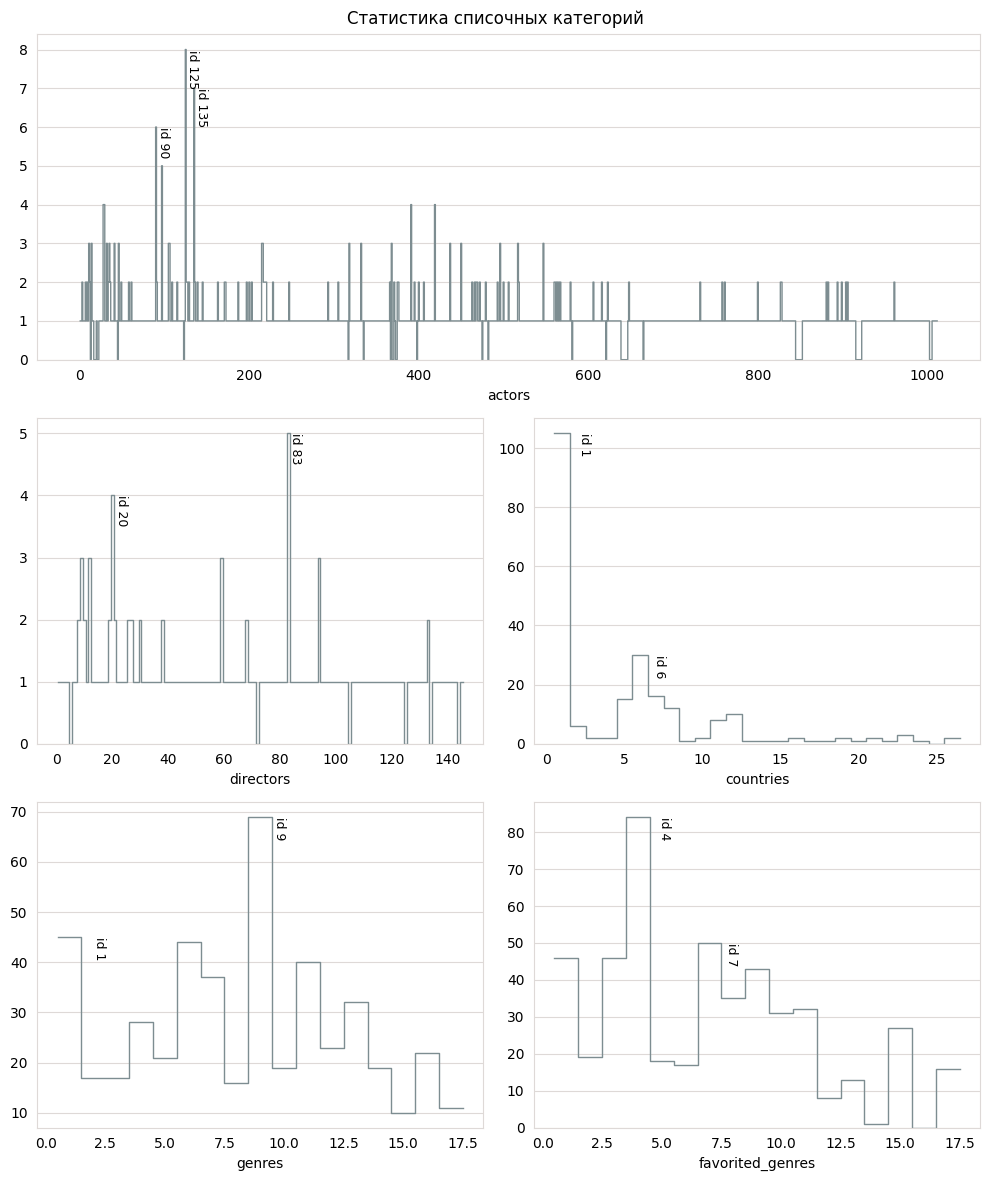

In [10]:
def hist(column, ax, highlights=0):
    
    """
    Рисует гистограмму списочных категориальных значений из указанной колонки с возможностью выделения наибольших значений.

    Параметры:    
    column : str -- Название колонки из датафрейма 'fixed_data', содержащий (!) списки категорий.
    ax : объект matplotlib Axis -- Ось, на которой будет нарисована гистограмма.
    highlights : int, необязательный (по умолчанию равен 0) --
        Количество наибольших значений для выделения на гистограмме. Если указано 0, выделения не происходит.

    - Для построения используется функция histplot из библиотеки seaborn.
    - Данные извлекаются из датафрейма 'fixed_data', который должен быть определен глобально.
    - Рассматриваются только уникальные идентификаторы фильмов из 'fixed_data'.
    
    Применяется внутри объявленного объекта figure
    (не создаёт самостоятельные сабплоты - их нужно создать перед вызовом функции)

    """
    
    x_vals = np.concatenate(fixed_data.drop_duplicates(subset='movie_id')[column].tolist())
    bins = np.max(x_vals)
    sns.histplot(x=x_vals,
                 color='#7d8d91',
                 bins=bins,
                 element='step',
                 lw=1,
                 discrete=True,
                 fill=False,
                 ax=ax)
    ax.xaxis.grid(False)
    
       
    if highlights > 0:
        hist_values, bin_edges = np.histogram(x_vals, bins=bins)        
        top3_indices = np.argsort(hist_values)[-highlights:]        
        top3_y = hist_values[top3_indices]
        top3_x = bin_edges[top3_indices]
        
        for x, y in zip(top3_x, top3_y):
            ax.text(x+1,
                    y,
                    f'id {int(np.ceil(x))}',
                    rotation=-90,
                    size=9,
                    verticalalignment='top',
                    horizontalalignment='left')
            
    plt.sca(ax)
    plt.xlabel(column)
    plt.ylabel('')

fig = plt.figure(figsize=(10, 12))

ax1=plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax2=plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax3=plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax4=plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax5=plt.subplot2grid((3, 2), (2, 1), colspan=1)

hist('actors', ax1, 3)
hist('directors', ax2, 2)
hist('countries', ax3, 2)
hist('genres', ax4, 2)
hist('favorited_genres', ax5, 2)

plt.suptitle('Статистика списочных категорий')
plt.tight_layout()
plt.show()
plt.close()

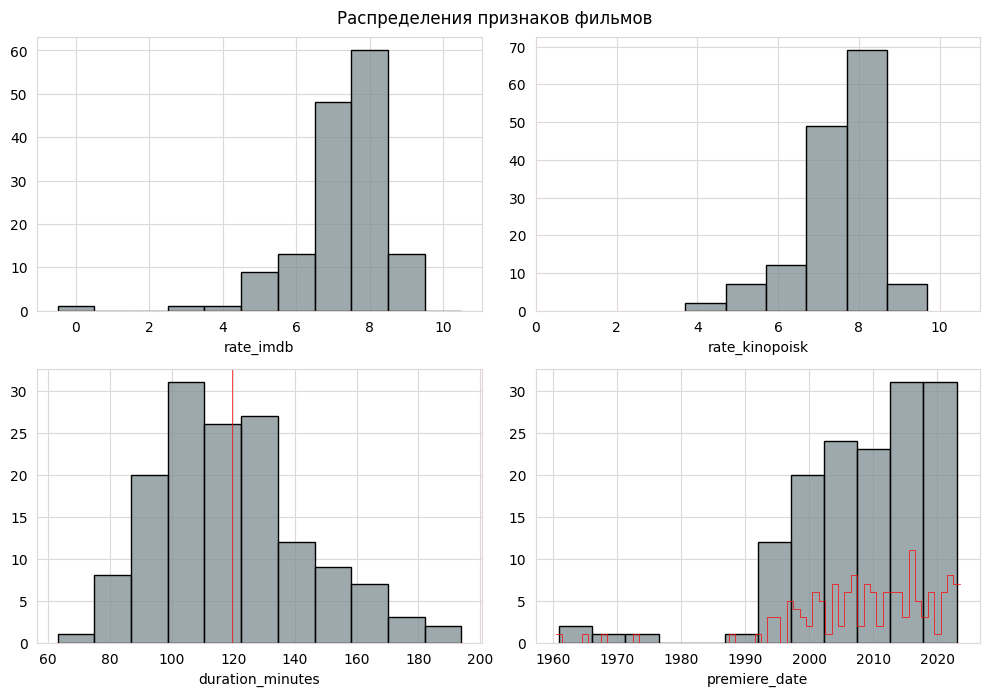

In [11]:
fig = plt.figure(figsize=(10, 10))

ax1=plt.subplot2grid((3, 2), (0, 0), colspan=1)
ax2=plt.subplot2grid((3, 2), (0, 1), colspan=1)
ax3=plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax4=plt.subplot2grid((3, 2), (1, 1), colspan=1)

sns.histplot(x=fixed_data.drop_duplicates(subset='movie_id')['rate_imdb'],
             discrete=True,
             color='#7d8d91',
             ax=ax1)

sns.histplot(x=fixed_data.drop_duplicates(subset='movie_id')['rate_kinopoisk'],
             discrete=True,
             color='#7d8d91',
             ax=ax2)

sns.histplot(x=fixed_data.drop_duplicates(subset='movie_id')['duration_minutes'],
             discrete=False,
             color='#7d8d91',
             ax=ax3)

sns.histplot(x=fixed_data.drop_duplicates(subset='movie_id')['premiere_date'],
             discrete=False,
             color='#7d8d91',
             ax=ax4)

sns.histplot(x=fixed_data.drop_duplicates(subset='movie_id')['premiere_date'],
             discrete=True,
             color='r',
             lw=.5,
             element='step',
             fill=False, ax=ax4)


for ax in fig.axes:
    plt.sca(ax)
    plt.ylabel('')

plt.sca(ax2)
plt.xlim([0, 11])
    
plt.sca(ax3)
plt.axvline(fixed_data.drop_duplicates(subset='movie_id')['duration_minutes'].mean(), c='r', lw=.5)

plt.suptitle('Распределения признаков фильмов')
plt.tight_layout()
plt.show()
plt.close()

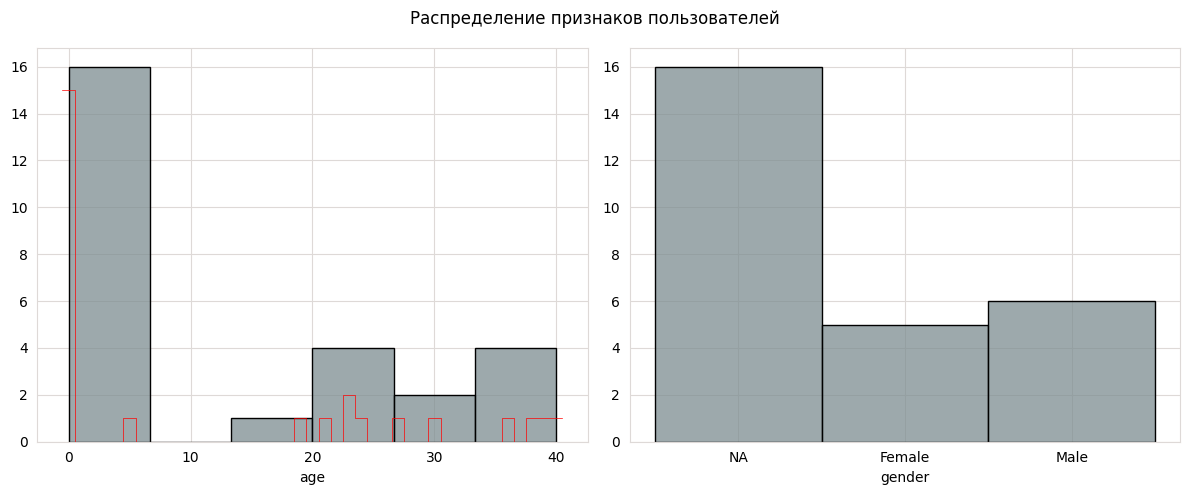

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=fixed_data.drop_duplicates(subset='user')['date_of_birth'], color='#7d8d91', ax=ax[0])
sns.histplot(x=fixed_data.drop_duplicates(subset='user')['date_of_birth'], discrete=True, color='r', lw=.5, fill=False,
             element='step', ax=ax[0])
sns.histplot(x=fixed_data.drop_duplicates(subset='user')['sex'].fillna('NA'), discrete=True, color='#7d8d91', ax=ax[1])

plt.sca(ax[0])
plt.xlabel('age')
plt.ylabel('')

plt.sca(ax[1])
plt.xlabel('gender')
plt.ylabel('')

plt.suptitle('Распределение признаков пользователей')
plt.tight_layout()
plt.show()
plt.close()

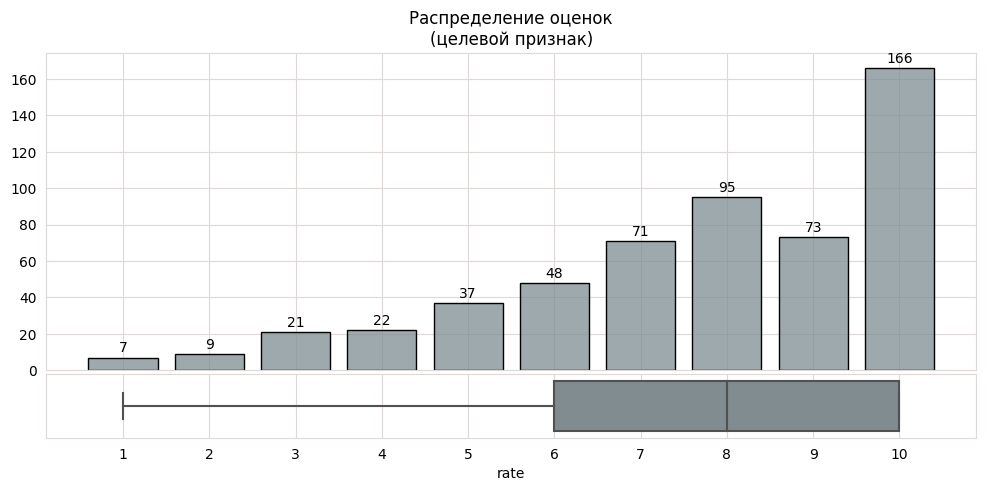

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), height_ratios=[5, 1], sharex=True)

rate_hist = sns.histplot(x=fixed_data['rate'],
                         color='#7d8d91',
                         shrink=.8,
                         discrete=True,
                         ax=ax[0])
sns.boxplot(x=fixed_data['rate'], color='#7d8d91')

for bar in rate_hist.patches:
    rate_hist.annotate(bar.get_height(),
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        ha='center',
                        va='center',
                        size=10,
                        xytext=(0, 7),
                        textcoords='offset points')

x_ticks_range = list(range(1, 11))
plt.xticks(x_ticks_range, x_ticks_range)
plt.sca(ax[0])
plt.ylabel('')
plt.title('Распределение оценок\n(целевой признак)')
plt.subplots_adjust(hspace = 0.02)
plt.show()
plt.close()

## Подготовка признаков
##### (второй этап)

In [14]:
# Разделение на тренировочную и валидационную выборки
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    fixed_data.drop('rate', axis=1),
    fixed_data['rate'],
    shuffle=True,
    random_state=RANDOM,
    test_size=.2
)

In [15]:
# Создание препроцессора второго этапа (preprocessor_st2) для дополнительной предобработки данных:
# - Преобразование категориальных колонок в one-hot кодирование с удалением первой колонки
# - Масштабирование числовых колонок в диапазоне [0, 1] (MinMaxScaler)
# Все остальные колонки, которые не были указаны в `transformers`, будут переданы без изменений.

preprocessor_st2 = ColumnTransformer(
        transformers=[
            
            ('ohe_features',
             OneHotEncoder(sparse=False, drop='first'),
             ohe_encoding_columns),                       # One-hot кодирование для категориальных колонок
            
            ('numerical_features',
             MinMaxScaler(),
             numerical_encoding_columns),                  # Масштабирование для числовых колонок
            
        ],
        remainder='passthrough'
    )

In [16]:
# Применение второго препроцессора (обучение на X_train или на всех данных)
preprocessor_st2.fit(X_train_raw)
# preprocessor_st2.fit(fixed_data.drop('rate', axis=1))

X_train = pd.DataFrame(preprocessor_st2.transform(X_train_raw))
X_test = pd.DataFrame(preprocessor_st2.transform(X_test_raw))

In [17]:
# # сохранение вторичного препроцессора в бинарном формате
# # (испольщуется только в рамках разработки)
# joblib.dump(preprocessor_st2, 'stage2preprocessor')

In [18]:
display(X_train.head(3))
print(X_train.shape)
display(X_test.head(3))
print(X_test.shape)
print()
display(y_train.head(3))
print(y_train.shape)
display(y_test.head(3))
print(y_test.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.675,0.526882,0.285714,0.282443,1.0,0.854839,22.0,16.0,[11],"[117, 106, 122, 119, 118, 115, 121, 116, 120, ...","[15, 11, 10, 7]",[18],[1]
1,0.0,1.0,0.575,0.698925,0.612245,0.473282,1.0,0.725806,18.0,107.0,"[12, 10]","[669, 667, 670, 673, 668, 666, 674, 671, 616, ...",[10],[107],"[8, 1, 5, 7]"
2,0.0,0.0,0.575,0.784946,0.673469,0.374046,0.888889,0.83871,10.0,9.0,"[12, 10]","[48, 54, 56, 51, 55, 49, 50, 53, 52, 57]","[4, 3]",[12],[1]


(439, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.0,1.0,0.677419,0.612245,0.557252,0.666667,0.967742,27.0,104.0,"[13, 12, 6, 1]","[632, 631, 638, 634, 630, 635, 637, 633, 629, ...","[11, 10, 9, 6, 4]",[104],[2]
1,0.0,0.0,0.75,0.849462,0.77551,0.442748,0.666667,0.758065,23.0,146.0,"[7, 6, 4]","[1006, 366, 1010, 881, 623, 547, 1011, 1007, 1...","[13, 4, 3]",[145],"[8, 1]"
2,1.0,0.0,1.0,0.741935,0.734694,0.557252,1.0,0.725806,27.0,45.0,"[2, 1]","[333, 332, 334, 318, 331]","[11, 10, 9, 6, 4]",[50],[1]


(110, 15)



175    10
358     2
26      6
Name: rate, dtype: object

(439,)


464     7
257    10
250     8
Name: rate, dtype: object

(110,)


In [19]:
def prepare_data(data: pd.DataFrame):
    
    """
    Подготавливает входные данные для дальнейшего использования в качестве признаков для обучения нейросети.
    
    Функция преобразует входные данные, основываясь на индексах и метриках данных, 
    и возвращает список массивов numpy.
    
    Параметры:    
    data : DataFrame
        Входные данные.
    
    Вывод:    
    inputs : list of numpy arrays
        Список массивов.
    
    """
    
    # загрузка предпросчитанных метрик :
    # количество, минимальные и максимальные значения уникальных id
    data_metrics_json = kh.data_metrics(mode='load')
    
    # Подготовка признаков на основе индексов во входных данных
    input_user = np.array(data[8].astype(int))
    input_movie = np.array(data[9].astype(int))
    input_gender_0 = np.array(data[0].astype(int))
    input_gender_1 = np.array(data[1].astype(int))
    input_age = np.array(data[2])
    input_imdb = np.array(data[3])
    input_kinopoisk = np.array(data[4])
    input_duration = np.array(data[5])
    input_age_limit = np.array(data[6])
    input_year = np.array(data[7])
    
    
    # Преобразование и дополнение списков жанров, актеров и т.д. до необходимой для получения эмбеддингов длины:
    # 1. Применяется функция к каждому элементу столбца (жанры, актеры и т.д.)
    # 2. Каждому списку добавляются нули так, чтобы его общая длина соответствовала заранее заданной максимальной длине,
    #    определенной в data_metrics_json для каждого типа данных (жанры, актеры и т.д.).
    # 3. Преобразованные списки затем конвертируются в numpy массивы.
    
    input_genres = np.array(
        data[10].apply(
            lambda x: x + [0] * (data_metrics_json['len']['genres'] - len(x))).values.tolist()
    )

    input_actors = np.array(
        data[11].apply(
            lambda x: x + [0] * (data_metrics_json['len']['actors'] - len(x))).values.tolist()
    )

    input_favorited_genres = np.array(
        data[12].apply(
            lambda x: x + [0] * (data_metrics_json['len']['favorited_genres'] - len(x))).values.tolist()
    )

    input_directors = np.array(
        data[13].apply(
            lambda x: x + [0] * (data_metrics_json['len']['directors'] - len(x))).values.tolist()
    )

    input_countries = np.array(
        data[14].apply(
            lambda x: x + [0] * (data_metrics_json['len']['countries'] - len(x))).values.tolist()
    )

    inputs = [
        input_user,
        input_movie,
        input_gender_0,
        input_gender_1,
        input_age,
        input_imdb,
        input_kinopoisk,
        input_duration,
        input_age_limit,
        input_year,
        input_genres,
        input_actors,
        input_favorited_genres,
        input_directors,
        input_countries
    ]

    # Приведение типа к np.float64
    inputs = [arr.astype(np.float64) for arr in inputs]
    
    # inputs = [arr.astype(np.float32) if arr.dtype == 'object' else arr for arr in inputs]    

    return inputs

In [20]:
X_train = prepare_data(X_train)
X_test = prepare_data(X_test)

In [21]:
for i, j in zip(X_train, X_test):
    print(i[:5], '...')
    print(i.shape)
    print(j[:5], '...')
    print(j.shape)
    print()

[22. 18. 10. 15. 18.] ...
(439,)
[27. 23. 27. 27. 10.] ...
(110,)

[ 16. 107.   9.  83.  83.] ...
(439,)
[104. 146.  45.   7.  98.] ...
(110,)

[0. 0. 0. 1. 0.] ...
(439,)
[1. 0. 1. 1. 0.] ...
(110,)

[0. 1. 0. 0. 1.] ...
(439,)
[0. 0. 0. 0. 0.] ...
(110,)

[0.675 0.575 0.575 0.975 0.575] ...
(439,)
[1.    0.75  1.    1.    0.575] ...
(110,)

[0.52688172 0.69892473 0.78494624 0.87096774 0.87096774] ...
(439,)
[0.67741935 0.84946237 0.74193548 0.70967742 0.8172043 ] ...
(110,)

[0.28571429 0.6122449  0.67346939 0.87755102 0.87755102] ...
(439,)
[0.6122449  0.7755102  0.73469388 0.55102041 0.79591837] ...
(110,)

[0.28244275 0.47328244 0.3740458  0.59541985 0.59541985] ...
(439,)
[0.55725191 0.44274809 0.55725191 0.2519084  0.49618321] ...
(110,)

[1.         1.         0.88888889 1.         1.        ] ...
(439,)
[0.66666667 0.66666667 1.         1.         0.66666667] ...
(110,)

[0.85483871 0.72580645 0.83870968 0.66129032 0.66129032] ...
(439,)
[0.96774194 0.75806452 0.72580645 0.580

## Разработка модели<a id="4"></a>  

Было рассмотрено несколько вариантов реализации архитектуры.



- 🔴 Модели на основе **векторных расстояний**: рекомендации на основе схожести векторных представлений объектов. Основная проблема этого подхода заключается в его ограниченности: пользователи, не оценившие ни одного фильма, не получат рекомендаций. Кроме того, рекомендации могут стать однообразными, так как система будет ориентироваться только на уже оцененные пользователем фильмы.  

- 🔴 **Контентный подход**: генерация рекомендаций на основе контента. Такой подход имеет те же проблемы, что и первый описанный. Если пользователь оценио фильм с определенным контентом, система и далее будет рекомендовать ему аналогичные.   

- 🔴 **Коллаборативная фильтрация**: основана на истории взаимодействия пользователей с элементами. В чистом виде такая система имеет ограниченную информативность.  

- 🟢 **Гибридная модель** (коллаборативная фильтрация с внешними признаками): комбинация контентно-ориентированных и коллаборативных подходов. Использование нешних признаков делает рекомендации более персонализированными и разнообразными. Сочетание с Использованием id пользователей и фильмов (элемент коллаборативной фильтрации) позволяет давать рекомендации новым пользователям и на новые (только появившиеся в базе) фильмы. Прогноз оценки (на котором базируется рекомендация) будет полностью случайным только в случае если новый пользователь также не указал о себе никакой информации.   

В условиях сокращенного времени на разработку было принято решение не тестировать различные подходы, а реализовать один, выбранный экспертным путём.  


#### Коллаборативная фильтрация в составе гибридной модели
Коллаборативная фильтрация — это метод рекомендации, основанный на анализе предпочтений пользователей. Её принцип заключается в том, чтобы находить сходства между пользователями или элементами и давать рекомендации на основе предпочтений схожих пользователей или связанных элементов.

К примеру, если пользователь **A** любит фильмы **1**, **2** и **3**, а пользователь **B** любит фильмы **2**, **3** и **4**, то они имеют похожие предпочтения. Исходя из этого, фильм **1** может быть рекомендован пользователю **B**, а фильм **4** — пользователю **A**.


#### Механика рекомендаций
Нейросеть в рамках регрессии должна предсказать потенциально самые высокие оценки для фильмов из числа тех, которым пользователь еще не ставил оценки. Далее эти спрогнозированные оценки будут ранжированы по убыванию, и будет выбираться только "топ" для выдачи рекомендации.  



In [22]:
def net(learning_rate=0.001,
        loss='mean_squared_error',
        layer1_units=10,
        layer2_units=5,
        layer3_units=None,
        layer4_units=None,
        layer5_units=None,
        layer6_units=None,
        layer1_activation='relu',
        layer2_activation='relu',
        layer3_activation='relu',
        layer4_activation='relu',
        layer5_activation='relu',
        layer6_activation='relu'):
    
    """
    Компиляция нейронной сети:

    Параметры:
        learning_rate (float): скорость обучения оптимизатора. default: 0.001
        loss (str): функция потерь для компиляции модели. default: mean_squared_error
        layer[n]_units (int): количество нейронов в слое
        layer[n]_activation (str): функция активации слоя

    Вывод:
        model (tf.keras.Model): скомпилированная модель.
    """
    
    # Фиксация случайных значений для воспроизводимости
    tf_random.set_seed(RANDOM)
    np.random.seed(RANDOM)
    
    # Оптимизатор
    optimizer = Adam(learning_rate=learning_rate)
    
    # Загрузка метрик для создания слоев ввода
    data_metrics_json = kh.data_metrics(mode='load')

    # Входные слои
    layer_user_id = Input(shape=[1], name='user')
    layer_movie_id = Input(shape=[1], name='movie')
    layer_gender0 = Input(shape=[1], name='gender0')
    layer_gender1 = Input(shape=[1], name='gender1')
    layer_age = Input(shape=[1], name='age')
    layer_imdb = Input(shape=[1], name='imdb')
    layer_kinopoisk = Input(shape=[1], name='kinopoisk')
    layer_duration = Input(shape=[1], name='duration')
    layer_age_limit = Input(shape=[1], name='age_limit')
    layer_year = Input(shape=[1], name='year')

    layer_genres = Input(shape=[data_metrics_json['len']['genres']],
                         name='genres')
    
    layer_actors = Input(shape=[data_metrics_json['len']['actors']],
                         name='actors')
    
    layer_favorites = Input(shape=[data_metrics_json['len']['favorited_genres']],
                            name='favorites')
    
    layer_directors = Input(shape=[data_metrics_json['len']['directors']],
                            name='directors')
    
    layer_countries = Input(shape=[data_metrics_json['len']['countries']],
                            name='countries')
    
    # Эмбеддинги для id пользователей
    user_embedding = Embedding(output_dim=10,
                               input_dim=int(data_metrics_json['max']['user']) + 5,
                               input_length=1,
                               name='user_embedding')(layer_user_id)
    user_embedding = Flatten()(user_embedding)
    
    # Эмбеддинги для id фильмов
    movie_embedding = Embedding(output_dim=10,
                                input_dim=int(data_metrics_json['max']['movie_id']) + 5,
                                input_length=1,
                                name='movie_embedding')(layer_movie_id)
    movie_embedding = Flatten()(movie_embedding)
    
    # Эмбеддинги для списочных id жанров
    genres_embedding = Embedding(output_dim=5,
                                 input_dim=data_metrics_json['max']['genres'] + 1,
                                 input_length=data_metrics_json['len']['genres'],
                                 mask_zero=True)(layer_genres)
    genres_embedding = Flatten()(genres_embedding)
    
    # Эмбеддинги для списочных id актеров
    actors_embedding = Embedding(output_dim=5,
                                 input_dim=data_metrics_json['max']['actors'] + 10,
                                 input_length=data_metrics_json['len']['actors'],
                                 mask_zero=True)(layer_actors)
    actors_embedding = Flatten()(actors_embedding)

    # Эмбеддинги для списочных id любимых жанров пользователя
    favorites_embedding = Embedding(output_dim=5,
                                    input_dim=data_metrics_json['max']['favorited_genres'] + 1,
                                    input_length=data_metrics_json['len']['favorited_genres'],
                                    mask_zero=True)(layer_favorites)
    favorites_embedding = Flatten()(favorites_embedding)    
    
    # Эмбеддинги для списочных id режиссеров
    directors_embedding = Embedding(output_dim=5,
                                    input_dim=data_metrics_json['max']['directors'] + 5,
                                    input_length=data_metrics_json['len']['directors'],
                                    mask_zero=True)(layer_directors)
    directors_embedding = Flatten()(directors_embedding)

    # Эмбеддинги для списочных id стран
    countries_embedding = Embedding(output_dim=5,
                                    input_dim=data_metrics_json['max']['countries'] + 1,
                                    input_length=data_metrics_json['len']['countries'],
                                    mask_zero=True)(layer_countries)
    countries_embedding = Flatten()(countries_embedding)

    # Объединение всех эмбеддингов
    x = Concatenate()(
        [
            user_embedding,
            movie_embedding,
            layer_gender0,
            layer_gender1,
            layer_age,
            layer_imdb,
            layer_kinopoisk,
            layer_duration,
            layer_age_limit,
            layer_year,
            genres_embedding,
            actors_embedding,
            favorites_embedding,
            directors_embedding,
            countries_embedding
        ]
    )
    
    # Полносвязные слои
    x = BatchNormalization()(x)
    x = Dense(layer1_units,
              activation=layer1_activation,
              kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = Dense(layer2_units,
              activation=layer2_activation,
              kernel_initializer='he_normal')(x)
    
    # Ниже второго слои создаются если в аргументах указано количество нейронов
    # в обратном случае остается 2 полносвязных слоя 
    if layer3_units:
        x = BatchNormalization()(x)
        x = Dense(layer3_units,
                  activation=layer3_activation,
                  kernel_initializer='he_normal')(x)

    if layer4_units:
        x = BatchNormalization()(x)
        x = Dense(layer4_units,
                  activation=layer4_activation,
                  kernel_initializer='he_normal')(x)

    if layer5_units:
        x = BatchNormalization()(x)
        x = Dense(layer5_units,
                  activation=layer5_activation,
                  kernel_initializer='he_normal')(x)

    if layer6_units:
        x = BatchNormalization()(x)
        x = Dense(layer6_units,
                  activation=layer6_activation,
                  kernel_initializer='he_normal')(x)
    
    # Выходной слой
    output = Dense(1, activation='linear')(x)

    # Создание и компиляция модели
    model = tf.keras.Model(
        inputs=[
            layer_user_id,
            layer_movie_id,
            layer_gender0,
            layer_gender1,
            layer_age,
            layer_imdb,
            layer_kinopoisk,
            layer_duration,
            layer_age_limit,
            layer_year,
            layer_genres,
            layer_actors,
            layer_favorites,
            layer_directors,
            layer_countries
        ], outputs=output
    )
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['mean_absolute_error'])

    return model

Для обучения подобрана модель со следующими аргументами:
- `learning_rate`: скорость обучения, заданная как `0.0025`.
- `loss`: функция потерь, заданная как 'mean_squared_error' (среднеквадратичная ошибка).
- `layer1_units ... layer6_units`: количество нейронов (юнитов) в соответствующих слоях. Для слоев заданы следующие значения:
  1. Слой: `200` юнитов
  2. Слой: `150` юнитов
  3. Слой: `100` юнитов
  4. Слой: `20` юнитов
  5. Слой: `8` юнитов
  6. Слой: `2` юнита
- `layer1_activation ... layer6_activation`: функции активации для соответствующих слоев. Для слоев заданы следующие функции активации:
  1. Слой: `ReLU`
  2. Слой: `LeakyReLU` с параметром `alpha 0.2`
  3. Слой: `ReLU`
  4. Слой: `LeakyReLU` с параметром `alpha 0.2`
  5. Слой: `ReLU`
  6. Слой: `LeakyReLU` с параметром `alpha 0.2`

In [23]:
# Инициализация сети
model = net(
        learning_rate=0.0025,
        loss='mean_squared_error',
        layer1_units=200,
        layer2_units=150,
        layer3_units=100,
        layer4_units=20,
        layer5_units=8,
        layer6_units=2,
        layer1_activation='relu',
        layer2_activation=LeakyReLU(alpha=.2),
        layer3_activation='relu',
        layer4_activation=LeakyReLU(alpha=.2),
        layer5_activation='relu',
        layer6_activation=LeakyReLU(alpha=.2))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 genres (InputLayer)         [(None, 7)]                  0         []                            
                                                                                                  
 actors (InputLayer)         [(None, 10)]                 0         []                            
                                                                                              

 batch_normalization_1 (Bat  (None, 200)                  800       ['dense[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 dense_1 (Dense)             (None, 150)                  30150     ['batch_normalization_1[0][0]'
                                                                    ]                             
                                                                                                  
 batch_normalization_2 (Bat  (None, 150)                  600       ['dense_1[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 dense_2 (Dense)             (None, 100)                  15100     ['batch_normalization_2[0][0]'
          

[Архитектура нейронной сети](https://raw.githubusercontent.com/eilyich/Kinotochka_model_dev/master/model/media/best_model.h5_img.png)

####  Обучение сети

In [24]:
def train(model,
          X,
          y,
          batch_size=100,
          epochs=100,
          validation_split=.2,
          verbose=0):
    
    """
    Функция обучает нейросеть

    Аргументы:
    - model (tf.keras.Model): Модель для обучения
    - X (array-like): Входные признаки для обучения
    - y (array-like): Целевой признак
    - batch_size (int, optional): Размер пакета для одной итерации. default 100.
    - epochs (int, optional): Количество эпох обучения. default 100.
    - validation_split (float, optional): Доля данных, которая будет использована для валидации. default 0.2 (20 %)
    - verbose (int, optional): Режим отображения процесса обучения
    (0 - не показывать,
     1 - показывать прогресс,
     2 - подробный прогресс)

    Вывод:
    - dict: Словарь, содержащий обученную модель и историю обучения.
    """
    
    # Инициализация чекпойнта для сохранения лучшей модели
    checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

    # Обучение модели с переданными аргументами и сохранением истории обучения
    history = model.fit(
        X,
        y,
        batch_size= batch_size,
        epochs=epochs,
        validation_split=validation_split,
        verbose=verbose,
        callbacks=[checkpoint]         # сохранение состояния сети на лучшей валидации
    )
    
    return {'model': model, 'history': history}

In [25]:
%%time

target = y_train.values.astype('float64')
# target = np.log(y_train.values.astype('float64'))

# обучение
output = train(model, X_train, target, 90, 200)

CPU times: total: 15.2 s
Wall time: 26.7 s


#### Валидация сети<a id="5"></a>  

In [26]:
# загрузка весов лучшей итерации
model = load_model('best_model.h5')

# загрузка финального состояния сети
# model = output['model']

history = output['history']

# получение прогноза оценок
preds = model.predict(X_test).flatten()
# preds = np.exp(model.predict(X_test).flatten())

4/4 [==============================] - 0s 7ms/step


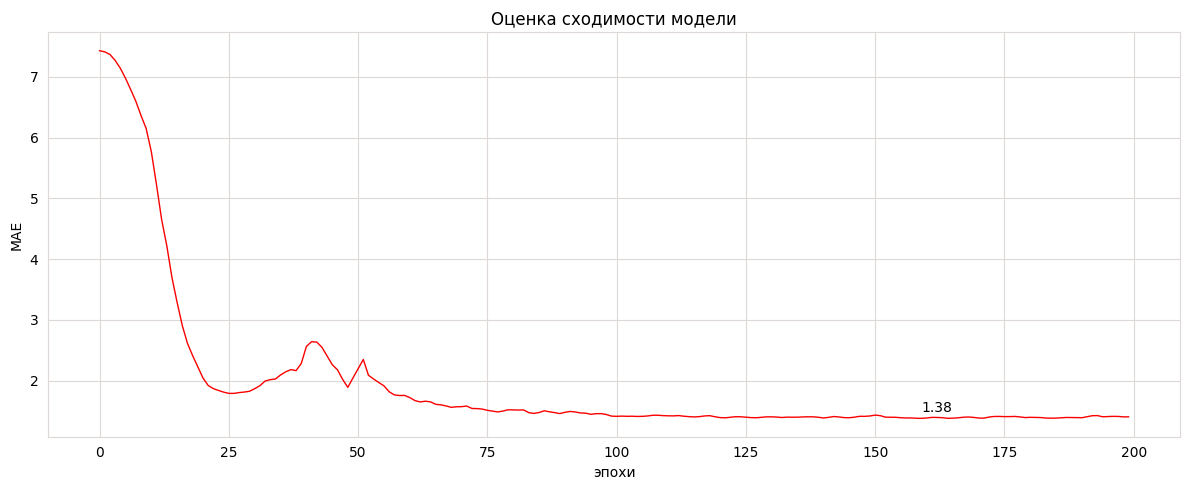

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))

arg_x = [i for i in range(len(history.history['val_mean_absolute_error']))]
arg_y = history.history['val_mean_absolute_error']

sns.lineplot(
    x=arg_x, y=arg_y, c='#fa0000', lw=1
)

plt.title('Оценка сходимости модели')
plt.text(arg_y.index(min(arg_y)), min(arg_y) + 0.1, f'{min(arg_y):.2f}')
plt.xlabel('эпохи')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()
plt.close()

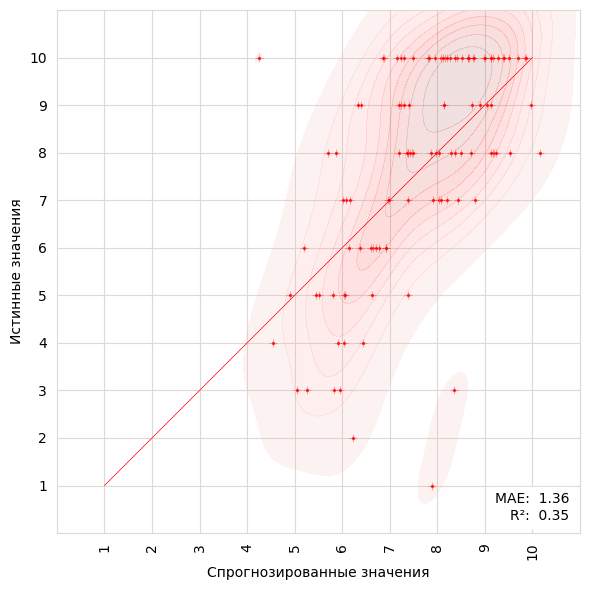

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.lineplot(x=[1, 10],
             y=[1, 10], ls='-', lw=0.5, c='#fa0000')

sns.kdeplot(y=y_test,
              x=preds, fill=True, color='#fa0000', alpha=.15)

sns.scatterplot(y=y_test,
              x=preds,
              s=30, color='#fa0000', marker=".", alpha=.8)

sns.scatterplot(y=y_test,
              x=preds,
              s=30, color='#fa0000', marker="+", alpha=.5)

plt.xlabel('Спрогнозированные значения')
plt.ylabel('Истинные значения')
plt.xticks(rotation=90)

plt.xlim([0, 11])
plt.ylim([0, 11])


local_mae = mean_absolute_error(y_test, preds)
mae_text = f'MAE:  {local_mae:.2f}'


local_r2 = r2_score(y_test, preds)
r2_text = f'R²:  {local_r2:.2f}'    

target_ticks = [i for i in range(1, 11)]
plt.yticks(target_ticks, target_ticks)
plt.xticks(target_ticks, target_ticks)
plt.text(x=0.98, y=0.02, ha='right', va='bottom', backgroundcolor='white',
         s= mae_text + '\n' + r2_text,
         transform=ax.transAxes)

plt.tight_layout()
plt.show()
plt.close()

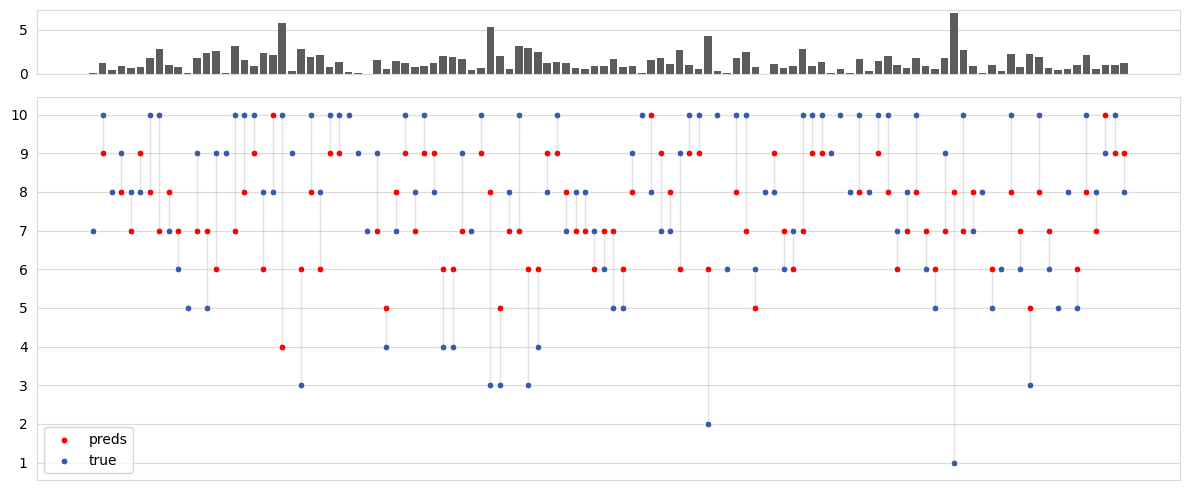

,true,preds,preds_raw,error
464,7,7,6.956881,0.043119
257,10,9,8.750603,1.249397
250,8,8,8.376303,0.376303
457,9,8,8.138784,0.861216
238,8,7,7.381233,0.618767
236,8,9,8.716595,0.716595
132,10,8,8.168832,1.831168
85,10,7,7.161383,2.838617
56,7,8,8.044170,1.04417
387,6,7,6.776038,0.776038


In [29]:
df_preds = pd.DataFrame({'true': y_test, 'preds_raw': preds})
df_preds['preds'] = df_preds.apply(lambda x: int(round(x['preds_raw'], 0)), axis=1)
df_preds['error'] = abs(df_preds['true'] - df_preds['preds_raw'])

fig, ax = plt.subplots(2, 1, figsize=(12, 5), height_ratios=[1, 6], sharex=True)

len_df_preds = [i for i in range(len(df_preds))]

sns.scatterplot(x=len_df_preds, y=df_preds['preds'], s=100, color='#fa0000', marker=".", ax=ax[1], label='preds')
sns.scatterplot(x=len_df_preds, y=df_preds['true'], s=100, color='#375bab', marker=".", ax=ax[1], label='true')
sns.barplot(x=len_df_preds, y=df_preds['error'], color='#5c5c5c', ax=ax[0])

for true, pred, xx in zip(df_preds['true'], df_preds['preds'], len_df_preds):
    sns.lineplot(x=[xx, xx],
                     y=[true, pred], ls='-', lw=0.5, c='#707070')


plt.xticks([])
plt.yticks([i for i in range(1, 11)])
plt.ylabel('')
plt.sca(ax[0])
plt.ylabel('')

plt.tight_layout()
plt.show()
plt.close()

display(df_preds[['true', 'preds', 'preds_raw', 'error']].head(10))

Модель подготовлена к внедрению, в рабочих скриптах реализован как механизм предсказания оценок пользователей, так и механизм переобучения/дообучения модели (возможна настройка графика обучения).